# Bayesian analysis for pulsar dispersion measure (DM)

Notebook for the UW 2018 Computational Physics course, module II.

In [25]:
using Pkg
using Plots
using PyCall
#Pkg.add("PyCall")
#Pkg.add("IJulia")
#Pkg.add("StatsBase")
using StatsBase
using LinearAlgebra
using Statistics

In [2]:
@pyimport numpy as nup
nup.inf

Inf

## Introduction, data and paramters

We want to test a model for the dispersion measure of pulsars (DM). The model includes an astrophysical contribution
\begin{equation}
DM=DM_{\text{astro}}+DM_{\text{dm}} \, .
\end{equation}

For the astrophysical contribution, we know
\begin{equation}
DM_{\text{astro}}= n_e d \, ,
\end{equation}
where $n_e$ is the electron density, estimated through the [YMW16](http://119.78.162.254/dmodel/) electron-density model, and $d$ is the distance determined with parallax.

For the dark matter contribution, we assume milli-charged dark matter of mass $m_{\text{dm}}$ and charge $q=e \epsilon$,
\begin{equation}
DM_{\text{astro}}= m_e \frac{\epsilon^2}{m_{\text{dm}}^2} \rho d \, ,
\end{equation}
where $\rho$ is the dark matter energy density of the Milky Way, assumed to be uniform.

We first upload the data set provided by the ATNF pulsar catalogue:

In [3]:
function get_data()
#n     PX       PXerr       DM        DMerr         ne
# when the error was missing (0) I set it to the last digit    
datatable= """
2     0.770     2.3e-01     6.4778     6.0e-04     0.009036
4     0.710     1.7e-01     9.02314     7.0e-05     0.007827
5     0.300     1.0e-01     22.177     5.0e-03     0.004931
6     0.700     2.0e-01     10.7645     1.5e-03     0.008292
7     2.530     7.0e-02     3.13695     0.01     0.020564
9     0.810     3.0e-02     10.3932     0.01     0.016935
10     2.770     7.0e-02     3.18321     1.6e-04     0.015919
11     0.370     1.2e-01     24.63109     1.8e-04     0.012689
12     0.470     3.0e-02     19.6191     3.0e-04     0.004691
13     0.400     2.0e-01     23.92344     9.0e-05     0.011004
15     0.860     1.8e-01     11.61944     2.0e-05     0.009608
16     4.200     1.4e+00     2.38     1.9e-01     0.009246
18     0.930     8.0e-02     10.922     6.0e-03     0.008167
19     0.731     2.2e-02     14.325     1.0e-02     0.008209
20     1.160     8.0e-02     9.25159     5.3e-04     0.008940
"""
#14     0.160     9.0e-02     61.25     5.0e-03     0.003488
#1     0.130     2.0e-02     34.9758     1.6e-03     0.000062  
#8     0.600     2.0e-01     13.3140     2.5e-03     0.044781  
#3     0.213     0.001     24.37     3.0e-03     0.000836    
#17     0.900     4.0e-01     11.10816     1.1e-04     0.024026  
    lines = split(datatable, '\n')
    lines = filter(x->(length(x)>0), lines)
    lines = filter(x->(length(x)>0), lines)

    x = zeros(length(lines))
    y = zeros(length(lines))
    yerr = zeros(length(lines))
    xerr = zeros(length(lines))
    ne = zeros(length(lines))
    for (i,line) in enumerate(lines)
        words = split(line, "     ")
        x[i] = 10^(-3)* parse(Float64, words[2]) # parallax in as
        y[i] = parse(Float64, words[4])      # DM in cm^-3 pc
        yerr[i] = parse(Float64, words[5])    # DM err
        xerr[i] = 10^(-3)* parse(Float64, words[3])   # parallax err
        ne[i] = parse(Float64, words[6])   # electron density cm^-3
    end
    return x,y,xerr,yerr,ne
end;

In [4]:
x,y,xerr,yerr,ne = get_data();

We define the main parameters, and se the units straight:
we define the dark matter density, the distance (from the parallax) and its error, the electron mass.

In [5]:
const rho = 0.3 * 10^9  # DM energy density (eV cm^-3)
d =1 ./x      # distance (pc)
derr =  d .* xerr ./ x #1 ./ (x .* x) .* xerr  # distance error (pc);
const m_e = 0.5109989461 * 10^6   # electron mass in eV

510998.94609999994

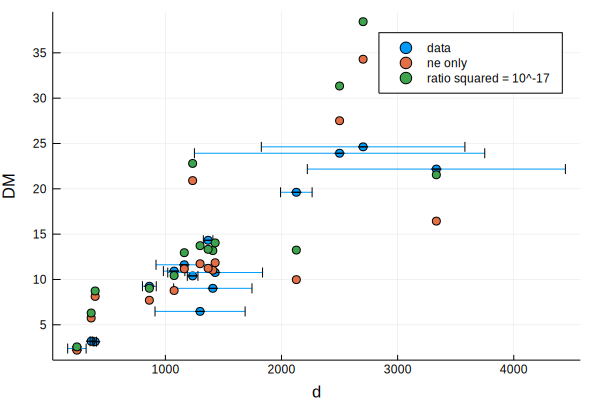

In [111]:
scatter(d, y, xerr=derr, yerr=yerr, label="data",xlabel="d", ylabel="DM") #xerr=derr,
scatter!(d , d .* ne, label="ne only")
scatter!(d , d .* ( ne .+ m_e .* rho .* 10^-17) , label="ratio squared = 10^-17")

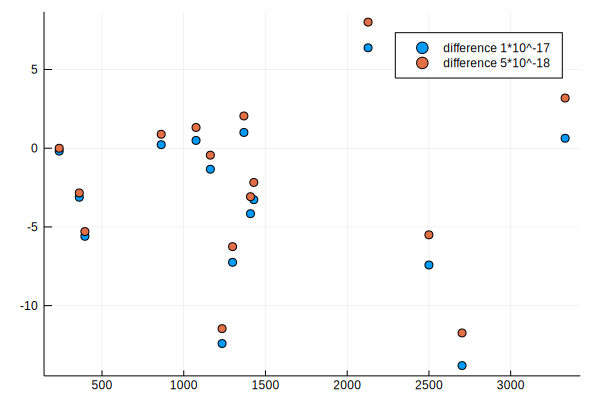

In [27]:
scatter(d , y .- d .* ( ne .+ m_e .* rho .* 1*10^-17) , label="difference 1*10^-17")
scatter!(d , y .- d .* ( ne .+ m_e .* rho .* 5*10^-18) , label="difference 5*10^-18")

In [8]:
diff= y .- d .* ( ne .+ m_e .* rho .* 5*10^-18)
diff[13]
1/(0.900 * 10^-3)

1111.1111111111109

# The eemc ensamble sampler

The code to follow is adaptated from the tutorial session 3 of the data analysis course module. 

We can finally write the likelihood for our hypothesis:

In [9]:
function ensemble_sampler(logprob_func, initial, nsteps)
    # A translation of the "emcee" ensemble sampler by Dan Foreman-Mackey,
    # http://arxiv.org/abs/1202.3665.  This is "Algorithm 3" in that paper.
    #
    # *logprob_func* is a log-posterior-probability function of the parameters.
    # *initial* must be an array with shape (Nwalkers, Nparams)
    # *nsteps* is the desired number of MCMC steps to take
    #
    nwalkers, nparams = size(initial)
    if (nwalkers % 2 != 0)
        println("NWalkers must be even")
        return
    end
    chain = zeros((nsteps, nwalkers, nparams))
    logprobs = zeros(nwalkers)
    nhalf = Int(nwalkers/2)
    # Start at initial parameter values
    params = initial
    for j in 1:nwalkers
        logprobs[j] = logprob_func(params[j,:])
    end
    # "Stretch move" parameter
    alpha = 2.
    # Tried moves
    tries = 0
    # Accepted moves
    accepts = 0
    for i in 1:nsteps
        # At each step, we first update one half of the ensemble (holding the other half fixed)
        # and then updated the second half (holding the first half, with its updated values, fixed)
        for half in 0:1
            for j in 1:nhalf
                # We're going to update the walker at index "me":
                me = half*nhalf + j
                # Draw a walker from the other half of the walkers
                other = (1-half)*nhalf + rand(1:nhalf)
                # Draw the "stretch move" distance
                z = ((alpha - 1.) * rand(Float64) + 1)^2 / alpha
                # Compute the parameter value -- it is along the line connecting "me" and "other"
                params_new = params[other,:] .+ z .* (params[me,:] - params[other,:])
                # Compute the log-prob at the new sample location
                logprob_new = logprob_func(params_new)
                # There is an extra term that weights the proposal distribution -- required to maintain
                # detailed balance.
                logproposal = (nparams-1) * log(z)
                tries += 1
                # Keep this new sample?
                if exp(logproposal + logprob_new - logprobs[me]) >= rand(Float64)
                    # Keep it!
                    params[me,:] = params_new
                    logprobs[me] = logprob_new
                    accepts += 1
                end
                # Record the chosen parameter values
                chain[i, me, :] .= params[me, :]
            end
        end
    end
    return chain, accepts/tries
end;

We still need to define the log likelihood, the prior and the posterior. Then, we can initialize and run the sampler. 

In [104]:
function mymodel_log_likelihood(x, y, sigma, ratioepsilondmsq, ne)
    return -0.5 * sum(@. (y - (ne + m_e * rho * ratioepsilondmsq) * x)^2 / sigma^2)
end;

function good_mymodel_lnl(pars)
    ratioepsilondmsq = pars
    mymodel_log_likelihood(d, y, yerr, ratioepsilondmsq, ne)
end;

#flat prior in a finite range:
function good_mymodel_logprob(pars)
    ratioepsilondmsq = pars[1]
    logposterior =  if 10^-30 < ratioepsilondmsq < 10^-10 return 0.0 else return -nup.inf end #-10^-13 < ratioepsilondmsq < 10^-13
   # logposterior = 0.
    return logposterior + good_mymodel_lnl(pars)
        end;

In [105]:
initial = [10^-17]  # initial guess for the paramters

jumpsizes = ones(length(initial)) * 1e-30
nparams = length(initial)

nwalkers = 20  # nwalker >> nparams

walkers = zeros((nwalkers, nparams)) 
for i in 1:nwalkers  # We initialize the walkers in a ball around the *initial* location.
    walkers[i,:] = initial + randn(nparams) .* jumpsizes
end

# Call the sampler!
nsteps = 10_000   
chain,acceptance = ensemble_sampler(good_mymodel_logprob, walkers, nsteps)
acceptance

0.831255

In [106]:
size(chain)
chain[6000,1,1]

5.041857694684187e-11

In [107]:
burnin = 1_000
plot(abs.(chain[burnin:end,:,1]), legend=false, ylabel="ratio squared", xlabel="MCMC step",yaxis=:log)

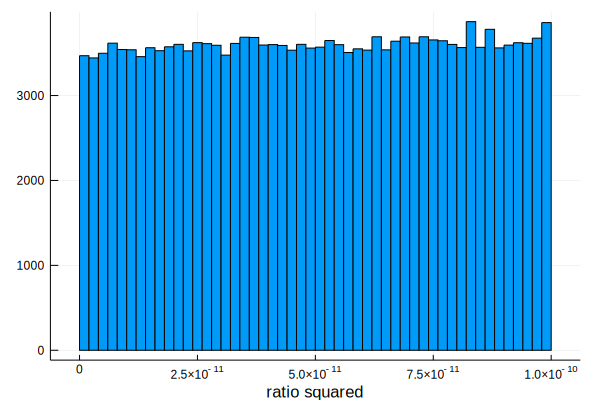

In [108]:
burnin = 1_000
flat = chain[burnin:end,:,:]
nb,nw,np = size(flat)
flat = reshape(flat, (nb*nw,np));
histogram(flat[:,1], xlabel="ratio squared", label="")

We are still not there. However, we can find the resulting ratio squared, the mean over the sample (after the initial stage) and compare it with the data. 

In [109]:
mean_ratiosq = mean(flat[:,1])

5.038349666091406e-11

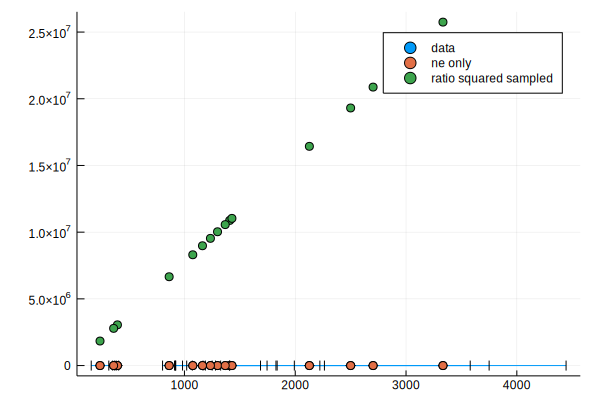

In [110]:
scatter(d, y, xerr=derr, yerr=yerr, label="data") #xerr=derr,
scatter!(d , d .* ne, label="ne only")
scatter!(d , d .* ( ne .+ m_e .* rho .* mean_ratiosq) , label="ratio squared sampled")